In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.io.json import json_normalize
from datetime import datetime
from plotly.offline import init_notebook_mode, iplot

channelGrouping - The channel via which the user came to the Store.

date - The date on which the user visited the Store.

fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

sessionId - A unique identifier for this visit to the store.

socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

visitNumber - The session number for this user. If this is the first session, then this is set to 1.

visitStartTime - The timestamp (expressed as POSIX time).

totals - This section contains aggregate values across the session.

In [2]:
def load_df_v2(csv_path, nrows=None):

    USE_COLUMNS = [
        'channelGrouping', 'date', 'fullVisitorId','sessionId',
        'socialEngagementType', 'totals', 'visitId',
        'visitNumber', 'visitStartTime'
    ]
    JSON_COLUMNS = ['totals']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows, usecols=USE_COLUMNS,
                    encoding='utf8', engine='c')
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
%%time
train_v2 = load_df_v2('train.csv')

Loaded train.csv. Shape: (903653, 14)
Wall time: 31.9 s


In [4]:
train_v2 = train_v2.drop('totals.bounces',axis=1)
train_v2 = train_v2.drop('totals.hits',axis=1)
train_v2 = train_v2.drop('totals.newVisits',axis=1)
train_v2 = train_v2.drop('totals.pageviews',axis=1)
train_v2 = train_v2.drop('totals.visits',axis=1)

In [5]:
train_v2.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,totals.transactionRevenue
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,NaN


In [6]:
train_v2["date"] = pd.to_datetime(train_v2["date"],format="%Y%m%d")
train_v2["visitStartTime"] = pd.to_datetime(train_v2["visitStartTime"],unit='s')




In [7]:
train_v2['new_date'] = [d.date() for d in train_v2['visitStartTime']]
train_v2['new_time'] = [d.time() for d in train_v2['visitStartTime']]



In [8]:
train_v2.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,totals.transactionRevenue,new_date,new_time
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,2016-09-02 15:33:05,NaN,2016-09-02,15:33:05
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,2016-09-03 05:22:27,NaN,2016-09-03,05:22:27
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,2016-09-03 01:16:26,NaN,2016-09-03,01:16:26
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,2016-09-03 05:40:13,NaN,2016-09-03,05:40:13
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,2016-09-02 13:23:20,NaN,2016-09-02,13:23:20


In [9]:
train_v2["day"] = train_v2['date'].dt.day
train_v2['month'] = train_v2['date'].dt.month
train_v2['weekday'] = train_v2['date'].dt.weekday
train_v2['weekofyear'] = train_v2['date'].dt.weekofyear

The day of the week with Monday=0, Sunday=6

In [10]:
print('Las características con un único valor:')
print(train_v2.columns[train_v2.nunique()==1])
train_v2 = train_v2.drop(labels=train_v2.columns[train_v2.nunique()==1],axis=1)

Las características con un único valor:
Index(['socialEngagementType'], dtype='object')


# Day

In [35]:
train_v2.day.value_counts()

1     32302
5     31403
17    31262
26    31113
4     30939
16    30668
15    30624
20    30407
27    30258
24    30236
19    30140
21    30123
28    30110
12    29469
3     29366
6     29363
10    29163
8     29118
14    29063
9     29055
2     28957
18    28909
7     28851
22    28837
23    28726
25    28549
13    28509
11    27563
30    26945
29    25955
31    17670
Name: day, dtype: int64

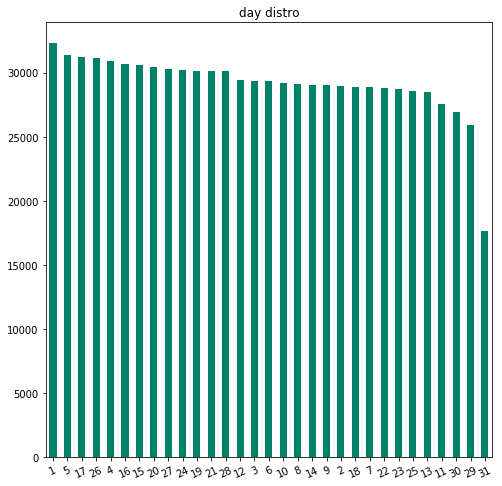

In [36]:
train_v2.day.value_counts().plot(kind="bar",title="day distro",figsize=(8,8),rot=25,colormap='summer')

# Month

In [37]:
train_v2.month.value_counts()

11    113972
10     97506
12     79124
8      77315
7      71812
9      71032
3      69931
4      67126
5      65371
1      64694
6      63578
2      62192
Name: month, dtype: int64

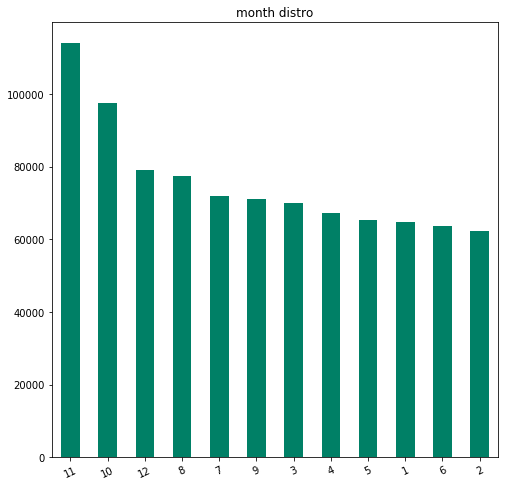

In [38]:
train_v2.month.value_counts().plot(kind="bar",title="month distro",figsize=(8,8),rot=25,colormap='summer')

# Weekday

In [39]:
train_v2.weekday.value_counts()

1    147279
2    146733
3    142399
0    140905
4    128331
6    100360
5     97646
Name: weekday, dtype: int64

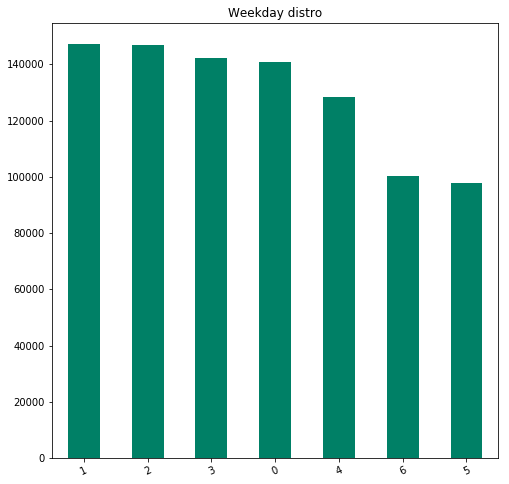

In [40]:
train_v2.weekday.value_counts().plot(kind="bar",title="Weekday distro",figsize=(8,8),rot=25,colormap='summer')

# ChannelGrouping

In [11]:
train_v2.channelGrouping.value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

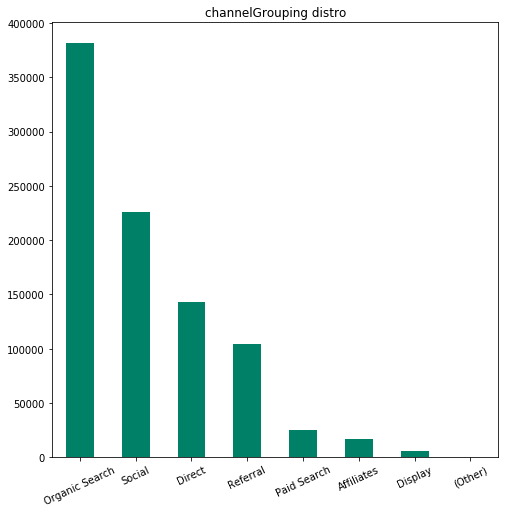

In [12]:
train_v2.channelGrouping.value_counts().plot(kind="bar",title="channelGrouping distro",figsize=(8,8),rot=25,colormap='summer')

In [13]:
train_v2["ingresos"] = train_v2["totals.transactionRevenue"]

In [14]:
train_v2.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,totals.transactionRevenue,new_date,new_time,day,month,weekday,weekofyear,ingresos
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,NaN,2016-09-02,15:33:05,2,9,4,35,NaN
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,NaN,2016-09-03,05:22:27,2,9,4,35,NaN
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,NaN,2016-09-03,01:16:26,2,9,4,35,NaN
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,NaN,2016-09-03,05:40:13,2,9,4,35,NaN
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,NaN,2016-09-02,13:23:20,2,9,4,35,NaN


# "Day - Revenue"

In [15]:
day_df = train_v2[["day", "ingresos"]].dropna()
day_df["ingresos"] = day_df.ingresos.astype(np.int64)
total_day_df = day_df.groupby(by=["day"],axis=0).sum()
print(total_day_df.sort_values(['ingresos'], ascending=False))

        ingresos
day             
5    80154830000
14   69708810000
16   68033690000
12   64844560000
18   63797430000
28   57519950000
7    56116200000
19   54276540000
27   54118750000
13   53656980000
17   53372210000
9    52984780000
1    52716530000
20   52529580000
21   50611780000
15   48509820000
6    47575870000
10   47099670000
24   44849540000
23   44490040000
8    44084840000
30   43312840000
26   42671970000
31   41393520000
22   41242200000
25   39778310000
2    37905200000
29   37115990000
3    35174580000
11   35169580000
4    25254650000


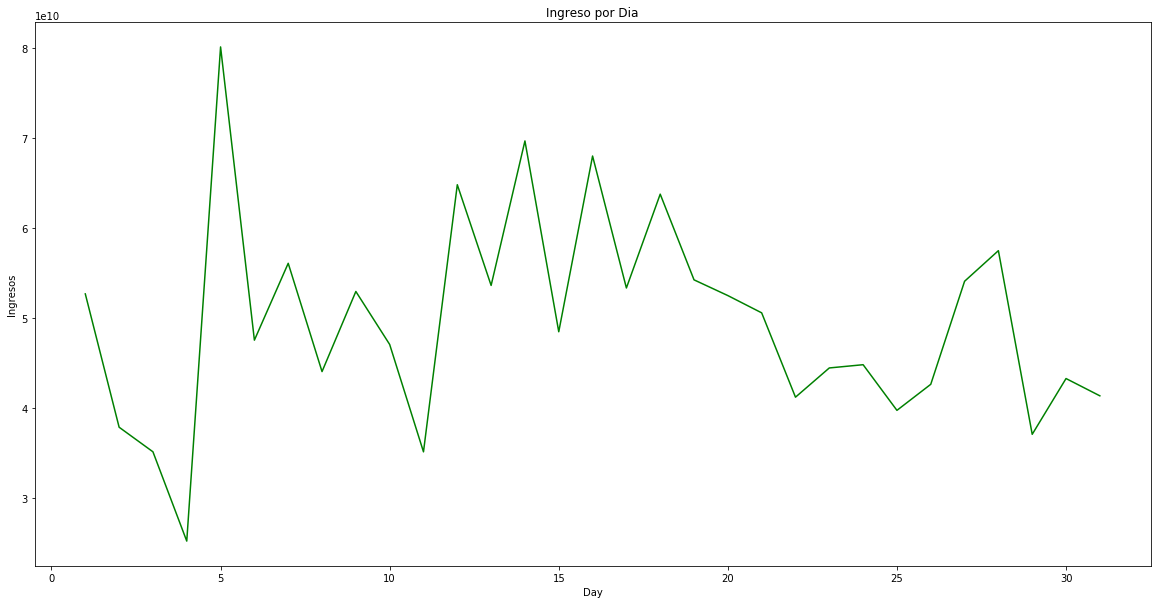

In [16]:
day_aux_df = day_df.groupby(by=["day"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Dia")
axes.set_xlabel("Day")
axes.set_ylabel("Ingresos")
axes.plot(day_aux_df["ingresos"],'g')

# "Month - Revenue"

In [17]:
month_df = train_v2[["month", "ingresos"]].dropna()
month_df["ingresos"] = month_df.ingresos.astype(np.int64)
total_month_df = month_df.groupby(by=["month"],axis=0).sum()
print(total_month_df.sort_values(['ingresos'], ascending=False))

           ingresos
month              
8      162971500000
4      158788800000
12     154557930000
3      130964270000
9      126031240000
7      124499280000
5      121711480000
6      121569490000
11     119013870000
10     113329070000
2      108756520000
1       97877790000


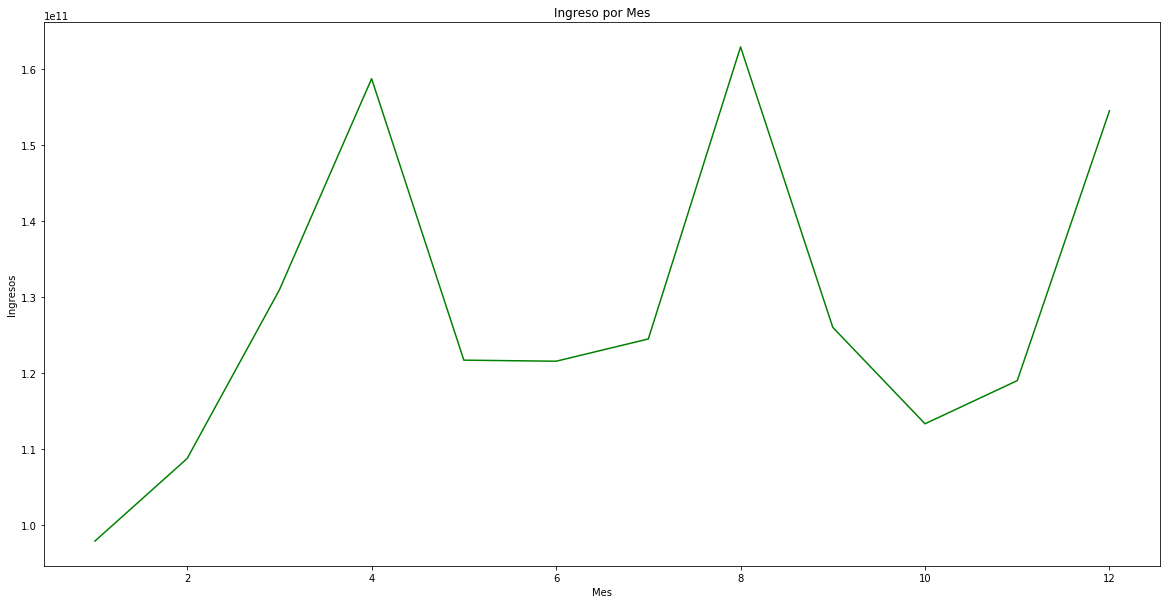

In [18]:
month_aux_df = month_df.groupby(by=["month"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Mes")
axes.set_xlabel("Mes")
axes.set_ylabel("Ingresos")
axes.plot(month_aux_df["ingresos"],'g')

# "Weekday - Revenue"

In [19]:
weekday_df = train_v2[["weekday", "ingresos"]].dropna()
weekday_df["ingresos"] = weekday_df.ingresos.astype(np.int64)
total_weekday_df = weekday_df.groupby(by=["weekday"],axis=0).sum()
print(total_weekday_df.sort_values(['ingresos'], ascending=False))

             ingresos
weekday              
1        307466240000
2        298488440000
0        272050260000
3        269170560000
4        258656660000
6         75841720000
5         58397360000


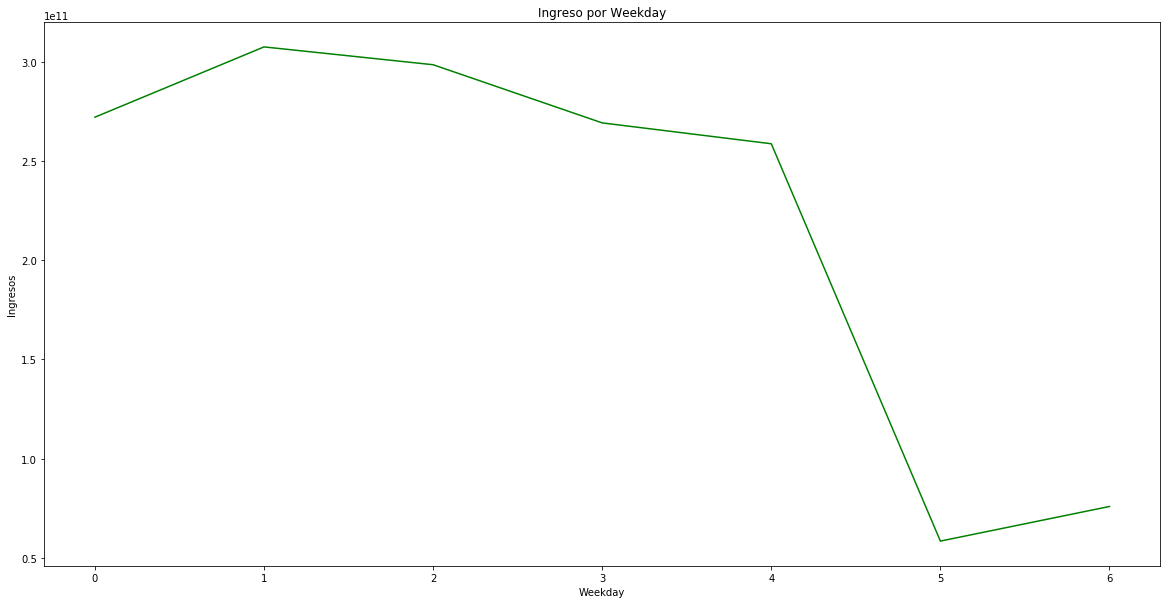

In [20]:
weekday_aux_df = weekday_df.groupby(by=["weekday"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Weekday")
axes.set_xlabel("Weekday")
axes.set_ylabel("Ingresos")
axes.plot(weekday_aux_df["ingresos"],'g')

# "channelGrouping" - "Revenue"

In [21]:
channelGrouping_df = train_v2[["channelGrouping", "ingresos"]].dropna()
channelGrouping_df["ingresos"] = channelGrouping_df.ingresos.astype(np.int64)
total_channelGrouping_df = channelGrouping_df.groupby(by=["channelGrouping"],axis=0).sum()
print(total_channelGrouping_df.sort_values(['ingresos'], ascending=False))

                     ingresos
channelGrouping              
Referral         651429910000
Direct           434840550000
Organic Search   326380510000
Display           78337460000
Paid Search       43558900000
Social             4916540000
Affiliates          597380000
(Other)               9990000


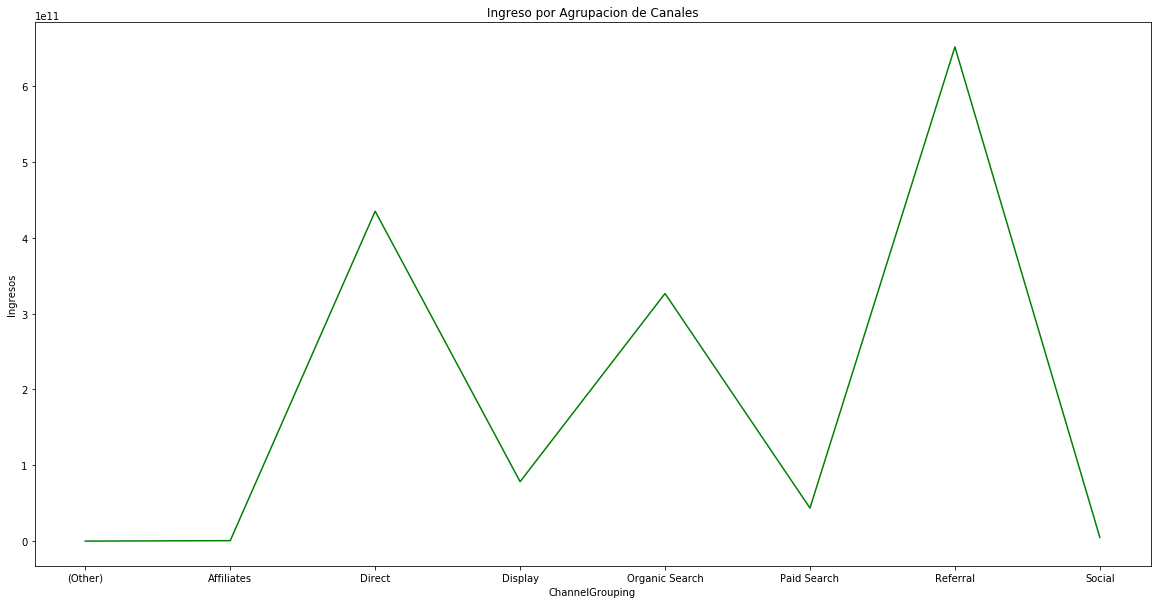

In [22]:
channelGrouping_aux_df = channelGrouping_df.groupby(by=["channelGrouping"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Agrupacion de Canales")
axes.set_xlabel("ChannelGrouping")
axes.set_ylabel("Ingresos")
axes.plot(channelGrouping_aux_df["ingresos"],'g')

# "Time - Revenue"

In [23]:
time_revenue_df = train_v2[["new_time", "ingresos"]].dropna()
time_revenue_df["ingresos"] = time_revenue_df.ingresos.astype(np.int64)
new_total_revenue_daily_df = time_revenue_df.groupby(by=["new_time"],axis=0).sum()
new_total_revenue_daily_df.head()

,ingresos
new_time,
00:00:00,16380000
00:00:11,31200000
00:00:27,19190000
00:00:29,26380000
00:00:31,16990000


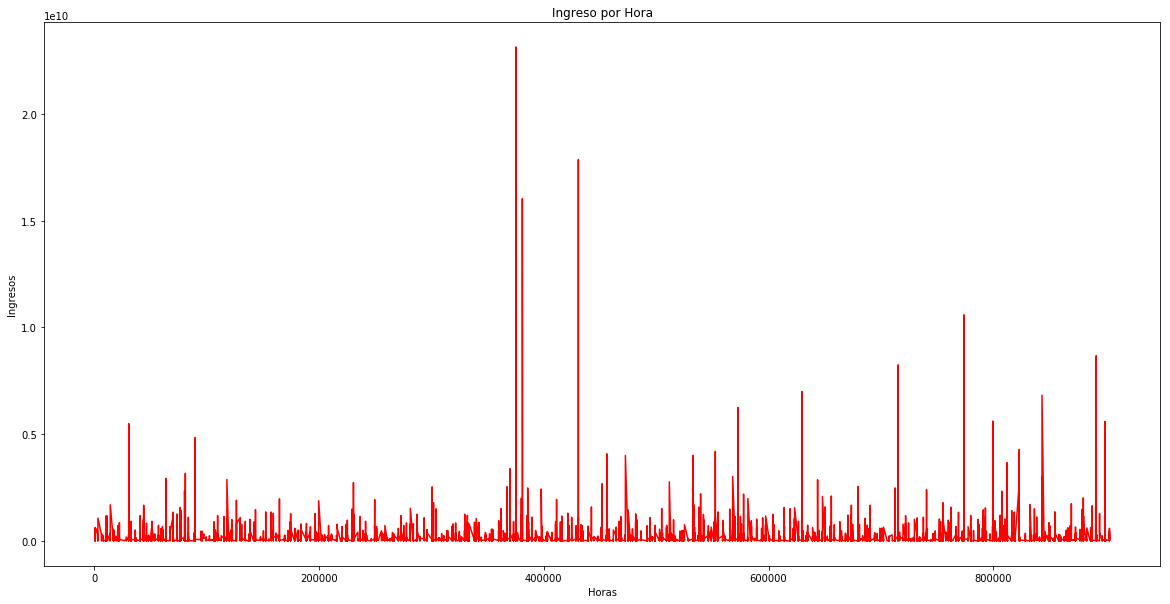

In [24]:
time_revenue_aux_df = time_revenue_df.groupby(by=["new_time"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Hora")
axes.set_xlabel("Horas")
axes.set_ylabel("Ingresos")
axes.plot(time_revenue_df["ingresos"],'r')

# "New_Date" - "Revenue"

In [25]:
new_revenue_datetime_df = train_v2[["new_date", "ingresos"]].dropna()
new_revenue_datetime_df["ingresos"] = new_revenue_datetime_df.ingresos.astype(np.int64)
new_total_revenue_daily_df = new_revenue_datetime_df.groupby(by=["new_date"],axis=0).sum()
new_total_revenue_daily_df.head()


,ingresos
new_date,
2016-08-01,5971730000
2016-08-02,1505520000
2016-08-04,821510000
2016-08-05,5827870000
2016-08-06,1794830000


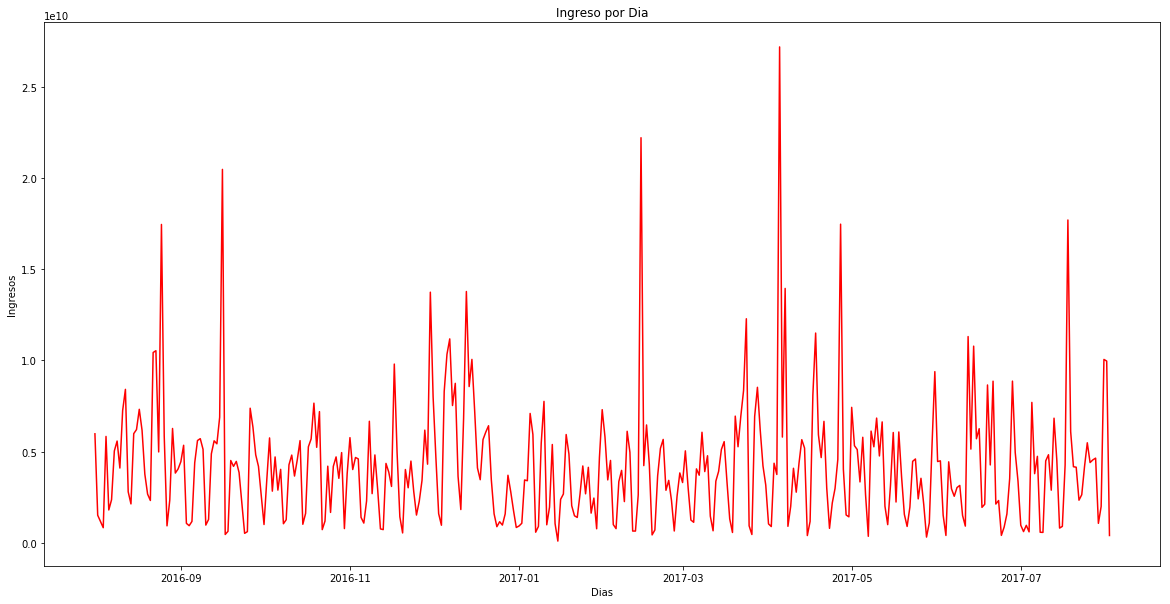

In [26]:
new_daily_revenue_df = new_revenue_datetime_df.groupby(by=["new_date"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Dia")
axes.set_xlabel("Dias")
axes.set_ylabel("Ingresos")
axes.plot(new_daily_revenue_df["ingresos"],'r')

# "Date" - "Revenue"

In [27]:
revenue_datetime_df = train_v2[["date", "ingresos"]].dropna()
revenue_datetime_df["ingresos"] = revenue_datetime_df.ingresos.astype(np.int64)
total_revenue_daily_df = revenue_datetime_df.groupby(by=["date"],axis=0).sum()
total_revenue_daily_df.head()


,ingresos
date,
2016-08-01,6116060000
2016-08-02,1361190000
2016-08-04,1182890000
2016-08-05,5594260000
2016-08-06,1891040000


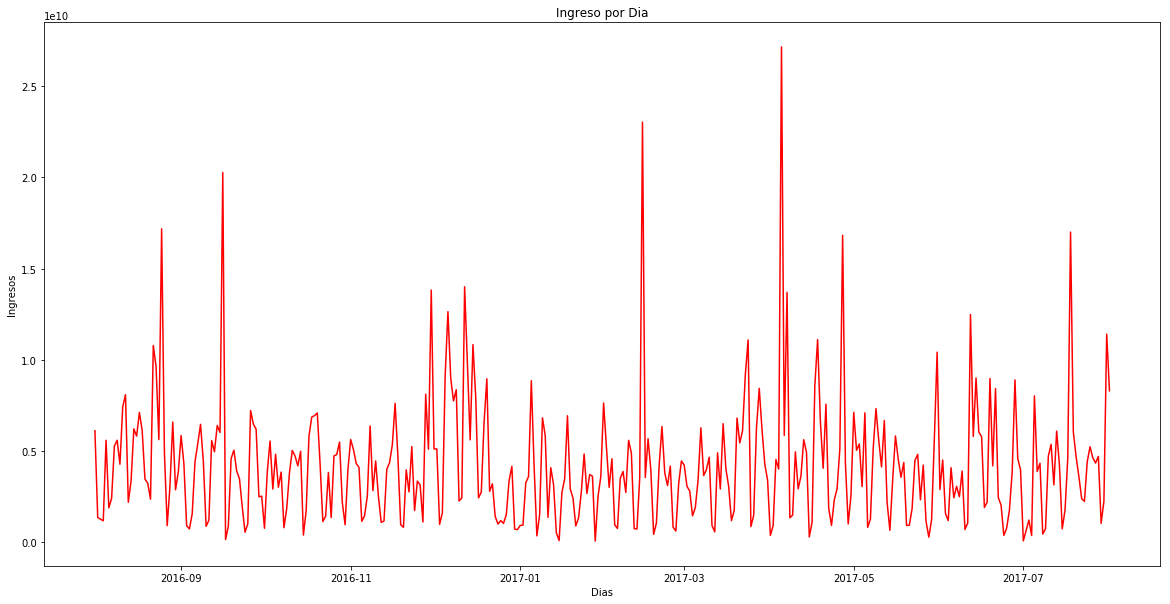

In [28]:
daily_revenue_df = revenue_datetime_df.groupby(by=["date"],axis = 0 ).sum()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Ingreso por Dia")
axes.set_xlabel("Dias")
axes.set_ylabel("Ingresos")
axes.plot(daily_revenue_df["ingresos"],'r')

# "New_Date" - "VisitNumber"

In [29]:
new_visit_datetime_df = train_v2[["new_date","visitNumber"]].dropna()
new_visit_datetime_df["visitNumber"] = new_visit_datetime_df.visitNumber.astype(np.int64)
new_total_visitNumber_daily_df = new_visit_datetime_df.groupby(by=["new_date"],axis=0).sum()
new_total_visitNumber_daily_df.head()

,visitNumber
new_date,
2016-08-01,4926
2016-08-02,7028
2016-08-03,6732
2016-08-04,6847
2016-08-05,6338


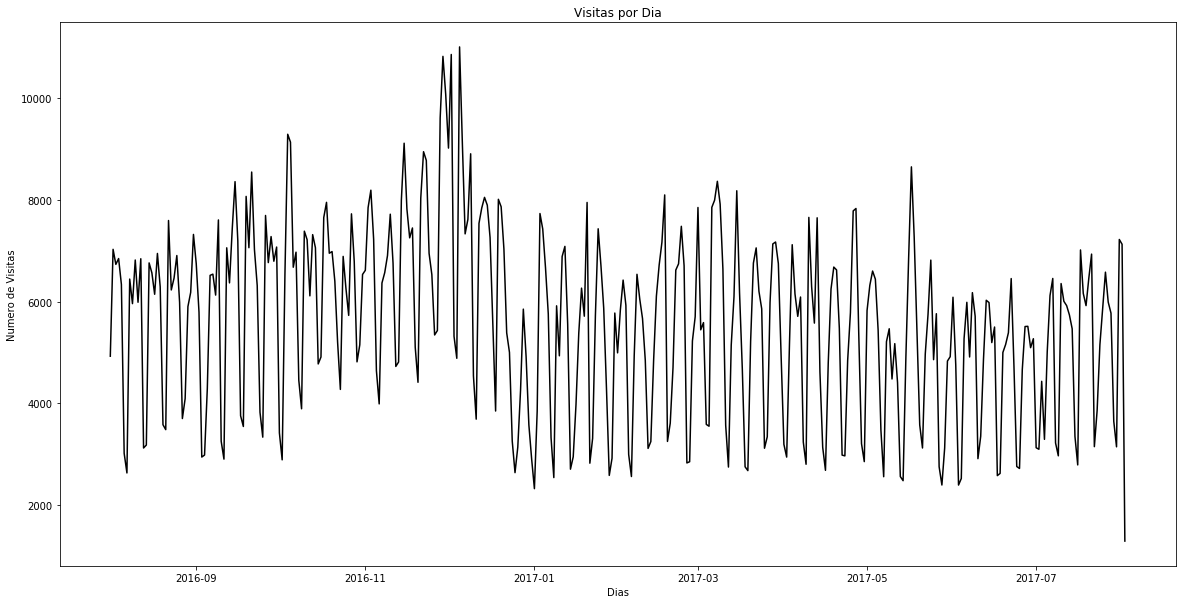

In [30]:
new_daily_visit_df = new_visit_datetime_df.groupby(by=["new_date"], axis = 0).sum()
fig, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("Visitas por Dia")
axes.set_xlabel("Dias")
axes.set_ylabel("Numero de Visitas")
axes.plot(new_daily_visit_df["visitNumber"],'black')

# "Date" - "VisitNumber"

In [31]:
visit_datetime_df = train_v2[["date","visitNumber"]].dropna()
visit_datetime_df["visitNumber"] = visit_datetime_df.visitNumber.astype(np.int64)
total_visitNumber_daily_df = visit_datetime_df.groupby(by=["date"],axis=0).sum()
total_visitNumber_daily_df.head()

,visitNumber
date,
2016-08-01,6320
2016-08-02,6929
2016-08-03,7233
2016-08-04,6456
2016-08-05,5686


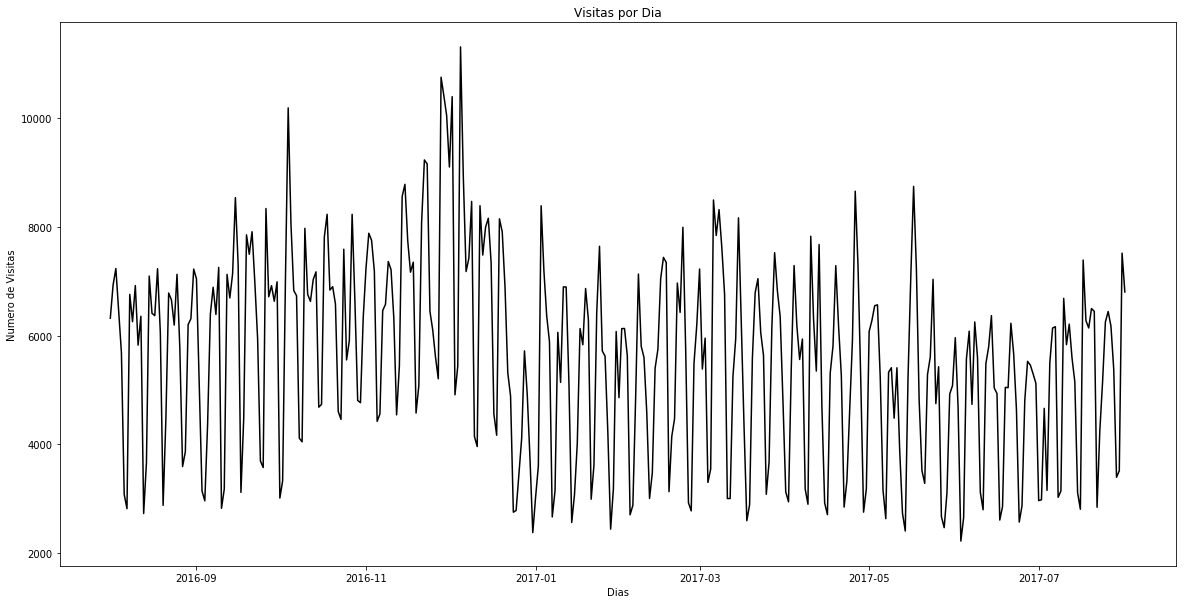

In [32]:
daily_visit_df = visit_datetime_df.groupby(by=["date"], axis = 0).sum()
fig, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("Visitas por Dia")
axes.set_xlabel("Dias")
axes.set_ylabel("Numero de Visitas")
axes.plot(daily_visit_df["visitNumber"],'black')

# "Merge visitNumber - date - ingresos"

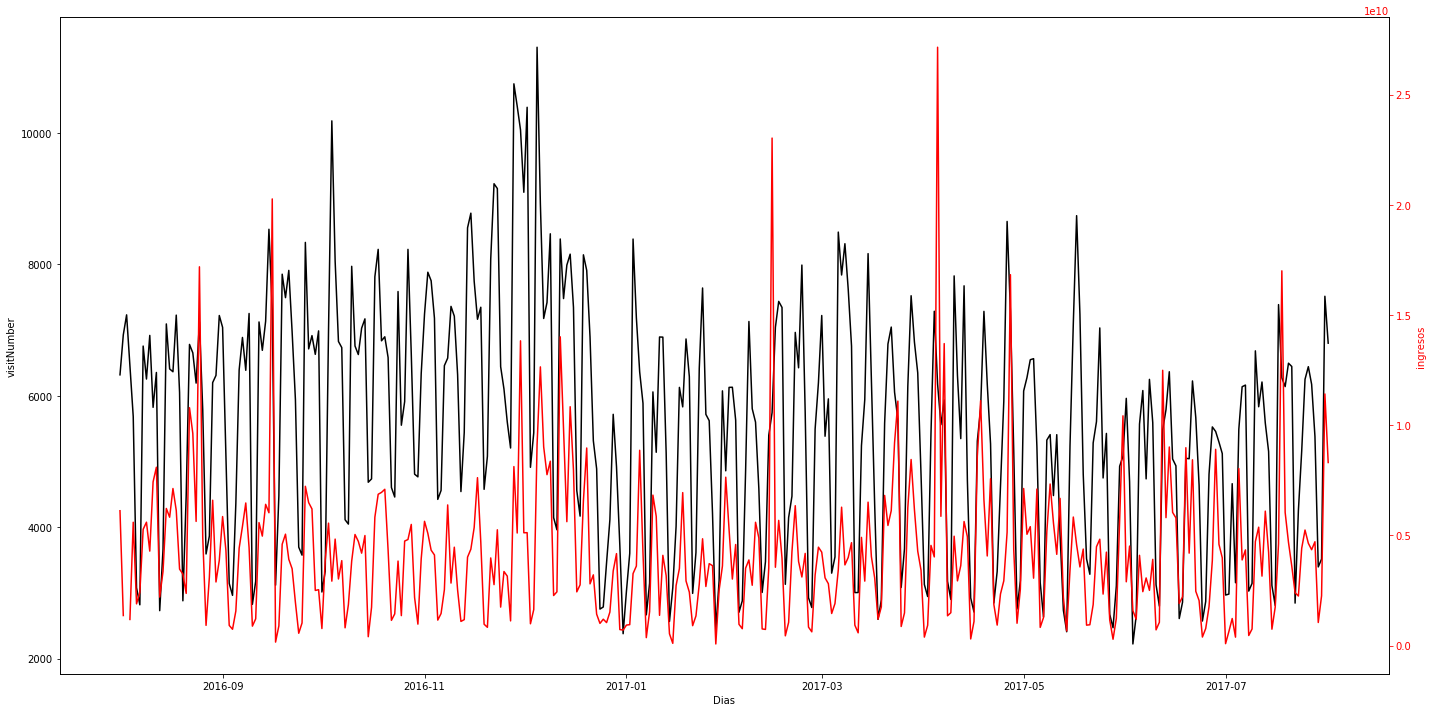

In [33]:
datetime_revenue_visits_df = pd.concat([total_revenue_daily_df,total_visitNumber_daily_df],axis=1)

fig, ax1 = plt.subplots(figsize=(20,10))
t = datetime_revenue_visits_df.index
s1 = datetime_revenue_visits_df["visitNumber"]
ax1.plot(t, s1, 'black')
ax1.set_xlabel('Dias')

ax1.set_ylabel('visitNumber', color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
s2 = datetime_revenue_visits_df["ingresos"]
ax2.plot(t, s2, 'red')
ax2.set_ylabel('ingresos', color='red')
ax2.tick_params('y', colors='red')
fig.tight_layout()

# "Merge visitNumber - new_date - ingresos"

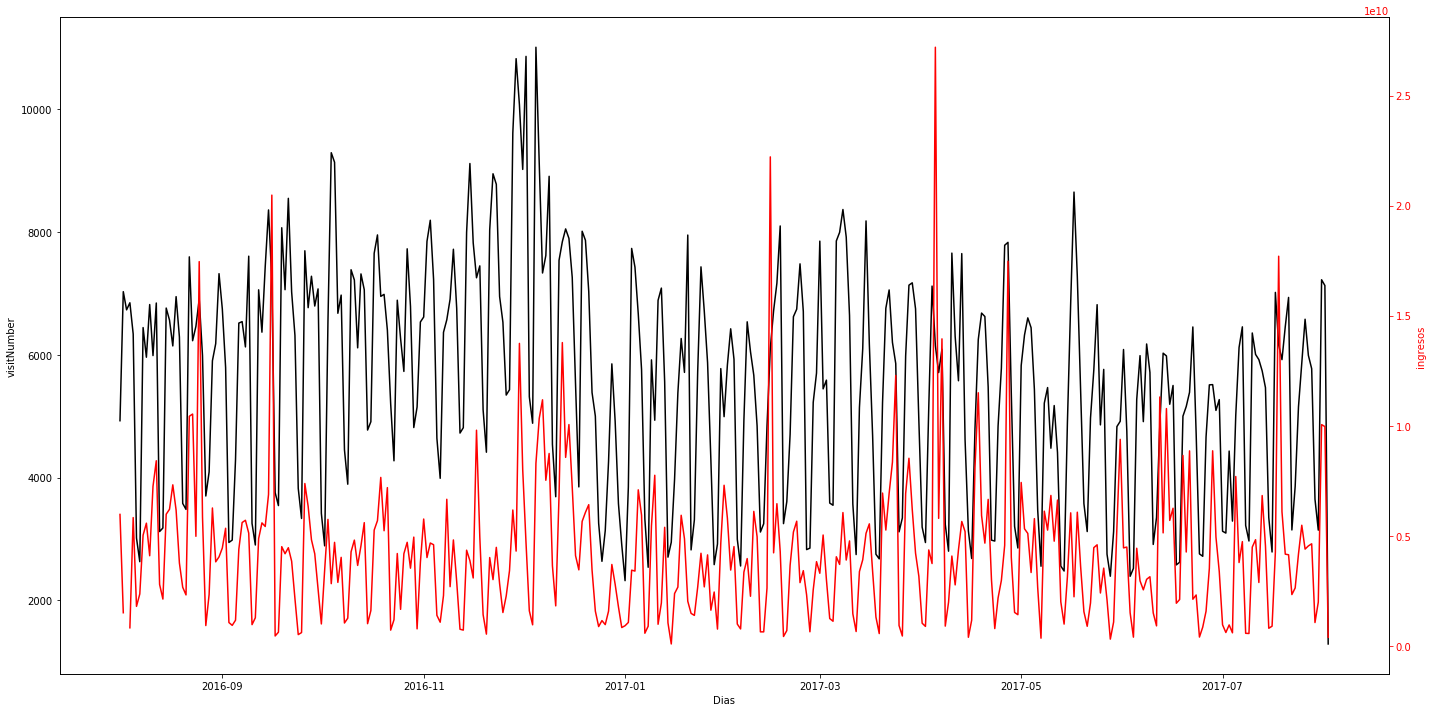

In [34]:
new_datetime_revenue_visits_df = pd.concat([new_total_revenue_daily_df,new_total_visitNumber_daily_df],axis=1)

fig, ax1 = plt.subplots(figsize=(20,10))
t = new_datetime_revenue_visits_df.index
s1 = new_datetime_revenue_visits_df["visitNumber"]
ax1.plot(t, s1, 'black')
ax1.set_xlabel('Dias')

ax1.set_ylabel('visitNumber', color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
s2 = new_datetime_revenue_visits_df["ingresos"]
ax2.plot(t, s2, 'red')
ax2.set_ylabel('ingresos', color='red')
ax2.tick_params('y', colors='red')
fig.tight_layout()

### Columnas con las que nos quedamos:
    
    channelGrouping

    visitNumber

    date

### Columnas con las que no nos quedamos:

    date
    
    new_date
    
    new_time
    
    day
    
    month
    
    weekday
    
    weekyear

    fullVisitorId

    sessionId

    socialEngagementType

    visitId

    visitStartTime

In [46]:
# train_v2.drop(['fullVisitorId','sessionId','visitId','visitStartTime','socialEngagementType'],axis=1, inplace=True)
# train_Id = train_v2['fullVisitorId']